In [3]:
from torchvision.transforms import Compose, ToTensor, RandomCrop, \
    RandomHorizontalFlip
from torchvision.datasets import CIFAR10

transforms = {
    'train': Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    'test': ToTensor(),
}

dataflow = {}
for split in ['test', 'train']:
    dataflow[split] = CIFAR10(
        root='../data/cifar10',
        train=(split == 'train'),
        download=True,
        transform=transforms[split],
    )

dataflow['train'], dataflow['test']

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../data/cifar10
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../data/cifar10
     Split: Test
     StandardTransform
 Transform: ToTensor())

# Visualization

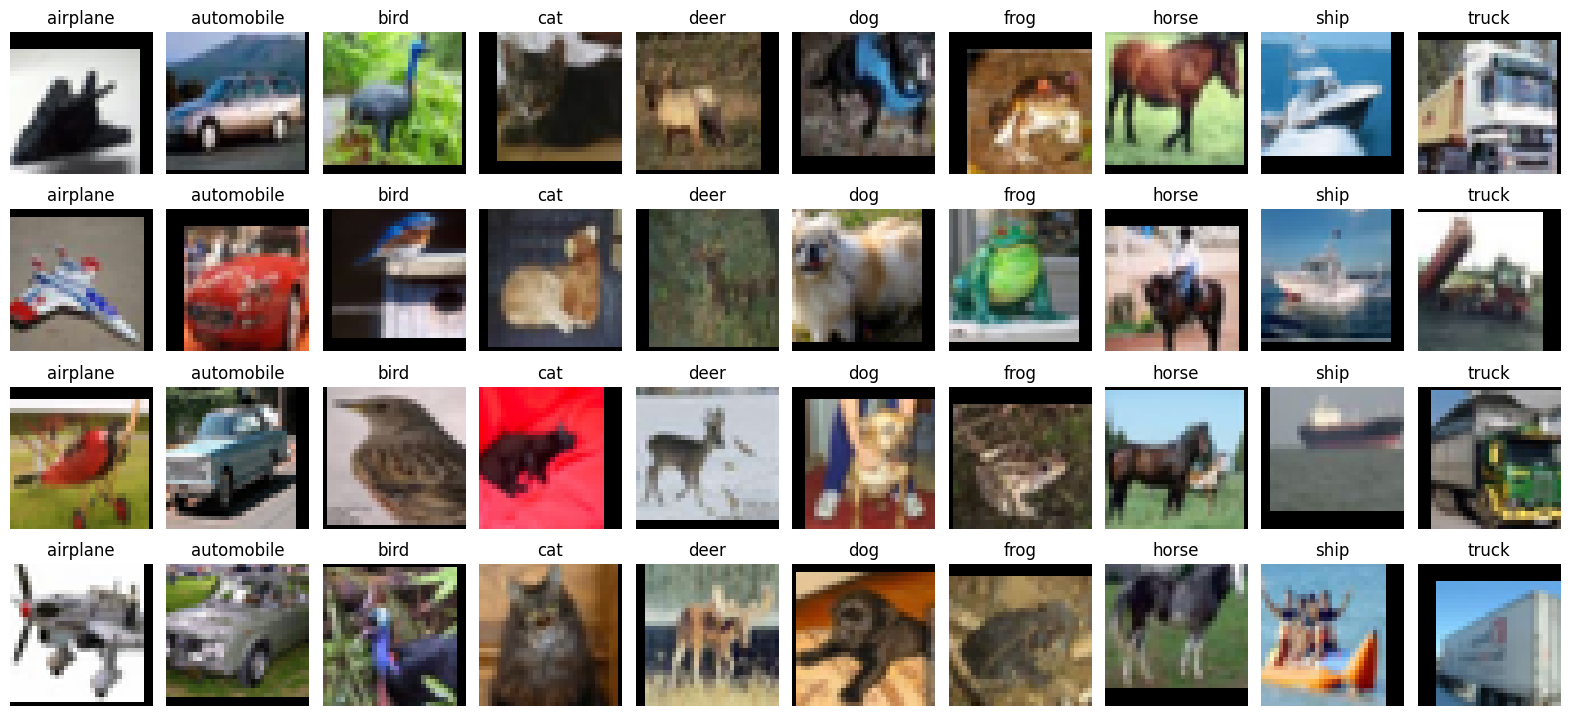

<Figure size 640x480 with 0 Axes>

In [ ]:
# draw grid 4x10, image x class
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

def visualize_cifar(dataflow: CIFAR10, save=False):
    """Visualize the dataset with 4 rows and 10 columns."""
    # get 40 samples from the training set, 10 classes = 10 list, each list has 
    # 4 images
    samples = [[] for i in range(10)]
    for img, label in dataflow:
        if len(samples[label]) < 4:
            samples[label].append(img)

    plt.figure(figsize=(20, 9))
    for idx in range(40):
        # get corresponding image, label (class ~ column)
        row = idx // 10
        col = idx % 10
        img = samples[col][row]
        label = dataflow.classes[col] 
        
        plt.subplot(4, 10, idx + 1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(label)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    if save:
        plt.savefig('../logs/EDA/cifar10.png')
    
visualize_cifar(dataflow['train'], save=True)

('deer', <matplotlib.image.AxesImage at 0x7416ecb084f0>)

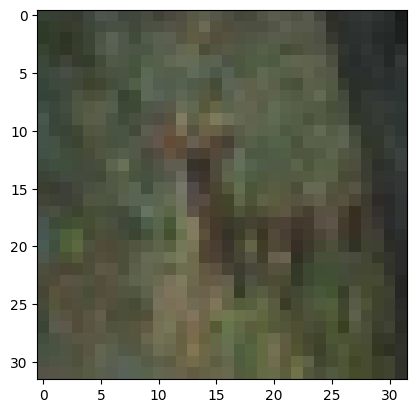

In [32]:
idx = 10
img, label  = a.data[idx], a.targets[idx]
import matplotlib.pyplot as plt
a.classes[label], plt.imshow(img)